In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.abspath("../")) 

import cv2
import numpy as np

from strikepoint.frames import FrameInfoReader
from IPython.display import Image, display


def showFrame(frame):
    ok, buf = cv2.imencode('.png', frame)
    if not ok:
        raise RuntimeError("Could not encode frame to PNG")
    display(Image(data=buf.tobytes()))

with FrameInfoReader("data/demo-three-hits.bin") as reader:
    frameInfoList = list(enumerate(reader.readAllFrameInfo()))


Found hit sequence ending at frame #112
  Time delta: 589.4 ms


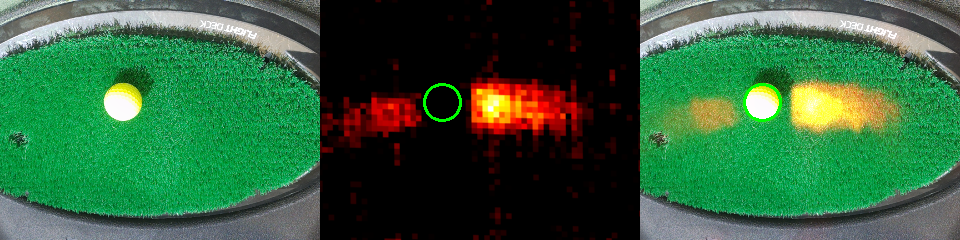

Found hit sequence ending at frame #217
  Time delta: 590.1 ms


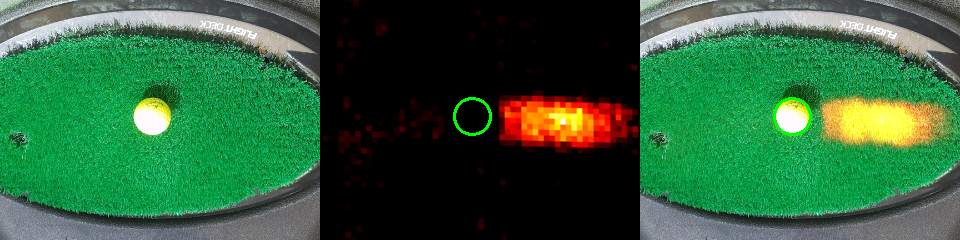

Found hit sequence ending at frame #297
  Time delta: 579.7 ms


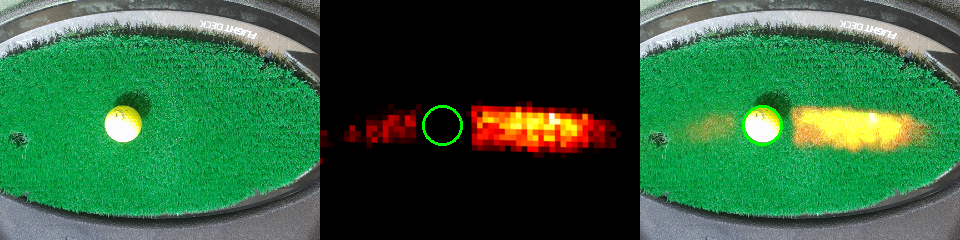

Found hit sequence ending at frame #373
  Time delta: 6368.1 ms


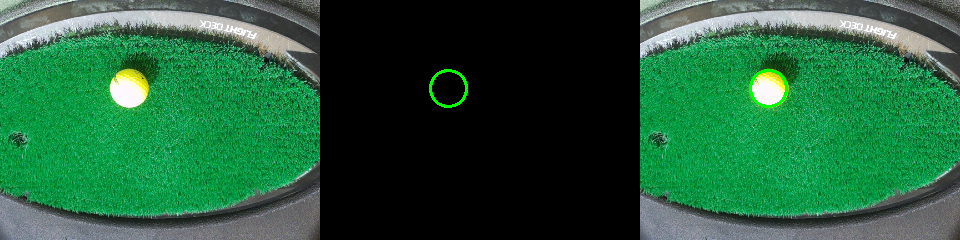

In [ ]:
from strikepoint.frames import FrameInfoReader
from strikepoint.imaging import findBrightestCircles, drawBrightestCircles

# Affine transform from calibration, hardcoded here for demo purposes
M_Therm2Vis = np.array([[1.38724782e+00, 2.01100450e-02, -7.83809764e+01],
                        [3.28716025e-02, 1.40602086e+00, -6.26867910e+01]])
M_Vis2Therm = cv2.invertAffineTransform(M_Therm2Vis)

foundHistory, foundSeq = list(), tuple([True]*3 + [False]*3)

for i, frameInfo in frameInfoList[::]:
    visFrame = frameInfo.rgbFrames['visual']
    Hv, Wv = visFrame.shape[:2]
    visCircles = findBrightestCircles(visFrame, 1, throwOnFail=False)
    foundSingleCircle = len(visCircles) == 1
    visCircle = visCircles[0] if foundSingleCircle else None
    foundHistory.append((frameInfo, foundSingleCircle, visCircle))

    if len(foundHistory) == len(foundSeq):
        if all(a == b[1] for a, b in zip(foundSeq, foundHistory)):
            print(f"Found hit sequence ending at frame #{i}")
            dt = foundHistory[-1][0].timestamp - foundHistory[0][0].timestamp
            print(f"  Time delta: {dt*1000:.1f} ms") 
            t1 = foundHistory[0][0].rgbFrames['thermal']
            t2 = foundHistory[-1][0].rgbFrames['thermal']
            v1 = foundHistory[0][0].rgbFrames['visual']
            c = foundHistory[0][2]

            beforeFrames = list(a[0].rawFrames['thermal']
                                for a in foundHistory if a[1])
            afterFrames = list(a[0].rawFrames['thermal']
                               for a in foundHistory if not a[1])
            thermalDiff = ((sum(afterFrames) / len(afterFrames)) -
                           (sum(beforeFrames) / len(beforeFrames)))
            thermalDiff = cv2.flip(thermalDiff, 0)
            thermalDiff = cv2.flip(thermalDiff, 1)

            # Eliminate the lowest 10% of values to reduce noise
            thermalDiff = np.clip(thermalDiff, thermalDiff.max()*0.1, None)
            thermalDiff = cv2.resize(thermalDiff, t1.shape[:2][::-1],
                                     interpolation=cv2.INTER_NEAREST)
            thermalDiff = cv2.normalize(
                thermalDiff, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            thermalDiff = cv2.applyColorMap(thermalDiff, cv2.COLORMAP_HOT)
            thermalDenoised = cv2.fastNlMeansDenoising(
                thermalDiff, None, h=50, templateWindowSize=7,
                searchWindowSize=21)

            thermalDiff = cv2.warpAffine(
                thermalDiff, M_Therm2Vis, (Wv, Hv), flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            thermalDenoised = cv2.warpAffine(
                thermalDenoised, M_Therm2Vis, (Wv, Hv), flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            final = cv2.add(v1, thermalDenoised)
            cv2.circle(thermalDiff, (int(c[0]), int(
                c[1])), c[2], (0, 255, 0), 2)
            cv2.circle(final, (int(c[0]), int(c[1])), c[2], (0, 255, 0), 2)
            showFrame(np.hstack((v1, thermalDiff, final)))

        foundHistory = foundHistory[1:]

In [3]:
for i, frameInfo in frameInfoList[365:]:
    # print(f"Frame #{i}")
    visFrame = frameInfo.rgbFrames['visual']
    Hv, Wv = visFrame.shape[:2]
    visCircles = findBrightestCircles(visFrame, 1, throwOnFail=False)
    foundSingleCircle = len(visCircles) == 1
    visCircle = visCircles[0] if foundSingleCircle else None
    foundHistory.append((frameInfo, foundSingleCircle, visCircle))

    if len(foundHistory) == len(foundSeq):
        if all(a == b[1] for a, b in zip(foundSeq, foundHistory)):
            print(f"Found hit sequence ending at frame #{i}")
            t1 = foundHistory[0][0].rgbFrames['thermal']
            t2 = foundHistory[-1][0].rgbFrames['thermal']
            v1 = foundHistory[0][0].rgbFrames['visual']
            c = foundHistory[0][2]

            beforeFrames = list(a[0].rawFrames['thermal']
                                for a in foundHistory if a[1])
            afterFrames = list(a[0].rawFrames['thermal']
                               for a in foundHistory if not a[1])
            thermalDiff = ((sum(afterFrames) / len(afterFrames)) -
                           (sum(beforeFrames) / len(beforeFrames)))
            thermalDiff = cv2.flip(thermalDiff, 0)
            thermalDiff = cv2.flip(thermalDiff, 1)

            # thermalDiffRev = np.clip(
            #     thermalDiff * -1, thermalDiffRev.max()*0.05, None)
            # thermalDiffRev = cv2.normalize(
            #     thermalDiffRev, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            # thermalDiffRev = cv2.resize(thermalDiffRev, t1.shape[:2][::-1],
            #                              interpolation=cv2.INTER_NEAREST)
            # thermalDiffRev = cv2.applyColorMap(
            #     thermalDiffRev, cv2.COLORMAP_HOT)
            # thermalDiffRev = cv2.warpAffine(
            #     thermalDiffRev, M_Therm2Vis, (Wv, Hv), flags=cv2.INTER_LINEAR,
            #     borderMode=cv2.BORDER_CONSTANT, borderValue=0)

            # Eliminate the lowest 10% of values
